In [1]:
#Initial Setup
import seaborn as sns
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna()
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [3]:
df = pd.read_csv('dass_modeling.csv')
df.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,voted,married,familysize,major,Depression,Depression_cat,Anxiety,Anxiety_cat,Stress,Stress_cat
0,4,28,3890,4,25,2122,2,16,1944,4,...,2,1,2,No Degree,27,3,34,4,40,4
1,4,2,8118,1,36,2890,2,35,4777,3,...,2,1,4,No Degree,24,3,17,3,27,3
2,3,7,5784,1,33,4373,4,41,3242,1,...,1,1,3,No Degree,39,4,12,2,17,1
3,2,23,5081,3,11,6837,2,37,5521,1,...,2,1,5,Biology,16,2,17,3,16,1
4,2,36,3215,2,13,7731,3,5,4156,4,...,2,1,4,Psychology,32,4,40,4,29,3


In [4]:
df.dtypes.value_counts()

int64     176
object      2
dtype: int64

In [5]:
df['country']=pd.factorize(df['country'], sort=True)[0]+1
df['major']=pd.factorize(df['major'], sort=True)[0]+1
df.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,voted,married,familysize,major,Depression,Depression_cat,Anxiety,Anxiety_cat,Stress,Stress_cat
0,4,28,3890,4,25,2122,2,16,1944,4,...,2,1,2,46,27,3,34,4,40,4
1,4,2,8118,1,36,2890,2,35,4777,3,...,2,1,4,46,24,3,17,3,27,3
2,3,7,5784,1,33,4373,4,41,3242,1,...,1,1,3,46,39,4,12,2,17,1
3,2,23,5081,3,11,6837,2,37,5521,1,...,2,1,5,10,16,2,17,3,16,1
4,2,36,3215,2,13,7731,3,5,4156,4,...,2,1,4,56,32,4,40,4,29,3


In [6]:
df.dtypes.value_counts()

int64    178
dtype: int64

In [8]:
scaler = MinMaxScaler()
df_rescaled = scaler.fit_transform(df)

In [9]:
# 95% of variance
pca = PCA(n_components = 0.95)
pca.fit(df_rescaled)
reduced_ninety_five = pca.transform(df_rescaled)
reduced_ninety_five.shape

(39737, 104)

This shows that 104 components will be sufficient to capture 95% of the variance.

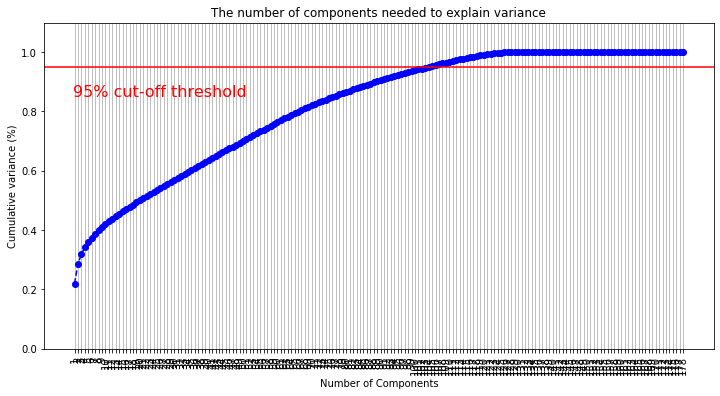

In [12]:
# Visualizing the PCA determination of number of components

pca = PCA().fit(df_rescaled)

plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, 179, step=1)
y = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, y, marker='o', linestyle='--', color='b')

plt.xlabel('Number of Components')
plt.xticks(np.arange(1, 179, step=1), rotation=90) #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative variance (%)')
plt.title('The number of components needed to explain variance')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

In [21]:
# Slice feature columns from dataframe for X
X = df.iloc[:,:172]

# Three different output columns to examine
dy = df['Depression_cat']

In [ ]:
# Create a DEPRESSION training and test split
X_train, X_test, y_train, y_test = train_test_split(X, dy, test_size=0.3, random_state=42)

# Apply scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply Principal Component Analysis
pca = PCA(n_components = 104)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)





# fit the model to the training set
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Calculate the predicted value for test dataset
y_pred = lin_reg.predict(X_test)

# Compute 5-fold cross-validation scores=
cv_scores = cross_val_score(lin_reg, X, y, cv=5)
print("5-Fold CV Scores: ", cv_scores)
print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))

In [ ]:
ay = df['Anxiety_cat']
sy = df['Stress_cat']